In [1]:
pip install duckdb pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import duckdb
import pandas as pd

db_path = './load-testing-sample.duckdb'

con = duckdb.connect(database=db_path)

# 데이터베이스의 모든 테이블 목록 가져오기
tables = con.execute("SHOW TABLES").fetchall()
print("Tables in database:", tables)

Tables in database: [('metrics',)]


In [5]:
pd.options.display.float_format = '{:.5f}'.format

In [6]:
table_name = 'metrics'
df = con.execute(f"SELECT * FROM {table_name}").fetchdf()

# DataFrame 출력
print(df)

                 timestamp    network_in   requests  num_of_instances  \
0      2024-05-30 09:20:42   11755.62012    0.00000                 1   
1      2024-05-30 09:20:47    4123.50098    0.00000                 1   
2      2024-05-30 09:20:53    3346.76367    0.00000                 1   
3      2024-05-30 09:20:58    4049.43872    0.00000                 1   
4      2024-05-30 09:21:03    3624.60693    0.00000                 1   
...                    ...           ...        ...               ...   
712248 2024-06-04 06:20:28 3268923.00000 1834.79272                 7   
712249 2024-06-04 06:20:33 3430668.75000 1809.18311                 7   
712250 2024-06-04 06:20:38 3623121.50000 1946.67810                 7   
712251 2024-06-04 06:20:43 4124254.75000 2169.24146                 7   
712252 2024-06-04 06:20:48 4057447.50000 2275.87012                 9   

        cpu_core_request      cpu  latency  
0                4.20000  0.00787      NaN  
1                4.20000  0.00685

In [9]:
df.dropna(subset=['network_in', 'cpu'], inplace=True)  # 결측치 제거

In [10]:
X = df[['network_in']].values
y = df['cpu'].values

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [13]:
# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [15]:
# Random Forest Regressor 모델 생성 및 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [25]:
# 모델 평가
score = model.score(X_test, y_test)
print(f'Model R^2 score: {score}')

Model R^2 score: 0.8206756493692103


In [19]:
# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

In [31]:
# 새로운 network_in 값으로 예측
new_network_in = np.array([[500000], [10000000]])  # interpolation과 extrapolation 예시
new_network_in_scaled = scaler.transform(new_network_in)
predicted_cpu = model.predict(new_network_in_scaled)

In [32]:
# 예측 결과 출력
for ni, cpu in zip(new_network_in.flatten(), predicted_cpu):
    print(f'Network in: {ni}, Predicted CPU: {cpu}')

Network in: 500000, Predicted CPU: 2.236097972523599
Network in: 10000000, Predicted CPU: 46.0842227935791


In [7]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

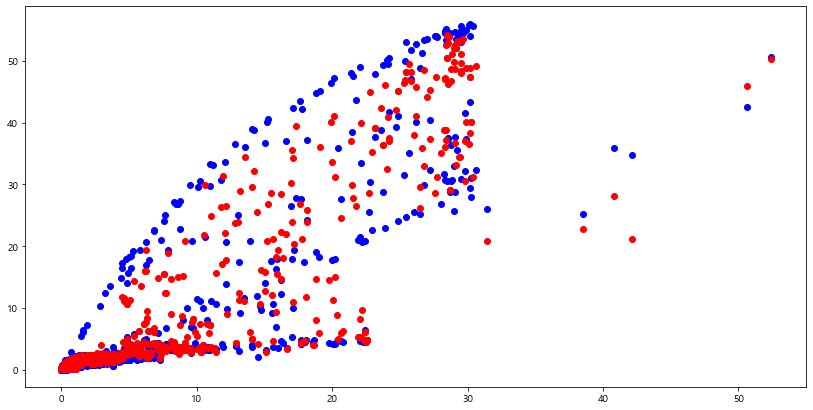

In [33]:
# 실제 값 vs 예측 값 (테스트 데이터)
plt.figure(figsize=(14, 7))
plt.scatter(X_test, y_test, color='blue', label='Actual data')
plt.scatter(X_test, y_pred, color='red', label='Predicted data')

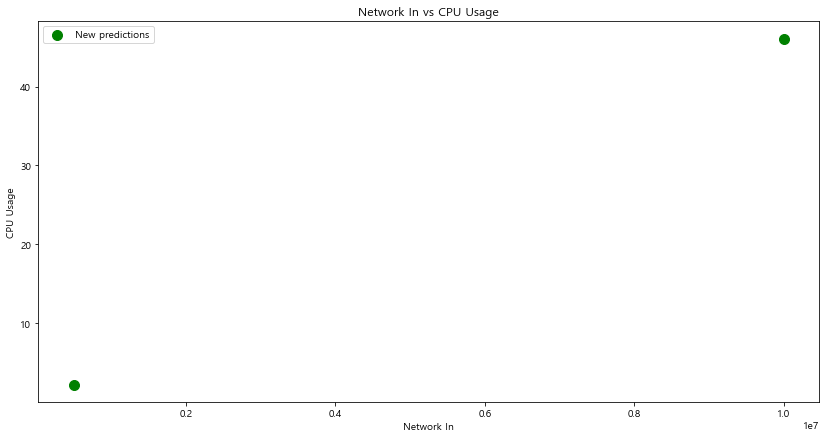

In [34]:
# 새로운 값 예측 결과
plt.figure(figsize=(14, 7))
plt.scatter(new_network_in, predicted_cpu, color='green', label='New predictions', s=100)
plt.xlabel('Network In')
plt.ylabel('CPU Usage')
plt.title('Network In vs CPU Usage')
plt.legend()
plt.show()